In [1]:
%load_ext autoreload
% autoreload 2

In [18]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from tensorboardX import SummaryWriter
from sklearn.metrics import f1_score
from tqdm import tqdm_notebook

from dataset import MNISTDataset
from models import CNN

In [19]:
def imshow(img, title=None):
    plt.imshow(img/(np.max(img)-np.min(img)))
    if title is not None:
        plt.title(title)
    plt.show()

In [20]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [21]:
data_dir = 'data/'
validation_split = 0.2
batch_size = 64
num_workers = 3
image_size = (64, 64)
num_classes = 10
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor()
])

In [22]:
train_set = MNISTDataset(os.path.join(data_dir, 'train_small.npz'), transform=transform)
val_set = MNISTDataset(os.path.join(data_dir, 'val_small.npz'), transform=transform)

In [23]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=num_workers)

In [26]:
dropout = 0.275

model = CNN(input_shape=(1, *image_size), dropout=dropout, num_classes=num_classes)
model = model.to(device)

criterion = nn.MultiLabelSoftMarginLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=0.005)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=4, verbose=True)

num_epochs = 50
train_steps_per_epoch = int((len(train_set)+1)/batch_size)
val_steps_per_epoch = int((len(val_set)+1)/batch_size)
models_dir = 'models/'
model_name = 'CNN-small-adam'

In [27]:
writer = SummaryWriter(comment=model_name)

best_val_loss = float('inf')
print('Started Training')
for epoch in range(num_epochs):
    
    model.train(True)
    train_loss = 0.0
    for i, data in tqdm_notebook(enumerate(train_loader, 0),
                                 total=train_steps_per_epoch,
                                 desc='Epoch {}: '.format(epoch)):
        x,y = data.values()
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        p = model(x)
        loss = criterion(p, y.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        if i >= train_steps_per_epoch:
            break
    writer.add_scalar('train_loss', train_loss / (len(train_set)/batch_size), epoch)
    
    model.eval()
    val_loss = 0.0
    y_true = None
    y_pred = None
    for i, data in enumerate(val_loader, 0):
        x,y = data.values()
        x = x.to(device)
        y = y.to(device)
        p = model(x)
        loss = criterion(p, y.float())
        val_loss += loss.item()
        if y_true is None:
            y_true = y
        else:
            y_true = torch.cat([y_true, y], dim=0)
            
        if y_pred is None:
            y_pred = y.byte()
        else:
            y_pred = torch.cat([y_pred, (torch.sigmoid(p).data > 0.5)], dim=0)

        if i >= val_steps_per_epoch:
            break
            
    y_true = torch.transpose(y_true, 0, 1).cpu().numpy()
    y_pred = torch.transpose(y_pred, 0, 1).cpu().numpy()

    f1score = []

    for i in range(num_classes):
        f1score.append(f1_score(y_true[i], y_pred[i]))

    avg_f1score = np.average(f1score)
    
    writer.add_scalar('validation_loss', val_loss / (len(val_set)/batch_size), epoch)
    writer.add_scalar('average f1-score on val. set', avg_f1score, epoch)
    
    print('train_loss: %.5f, validation_loss: %.5f, validation_f1-score: %.3f' % 
          (train_loss / (len(train_set)/batch_size), val_loss / (len(val_set)/batch_size), avg_f1score))
    
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), os.path.join(models_dir, model_name))
        best_val_loss = val_loss
        print('Model Saved!')
        
    train_loss = 0.0
    val_loss = 0.0
            
print('Finished Training')

Started Training


train_loss: 0.41955, validation_loss: 0.36121, validation_f1-score: 0.062
Model Saved!


train_loss: 0.34502, validation_loss: 0.33665, validation_f1-score: 0.109
Model Saved!


train_loss: 0.32297, validation_loss: 0.30807, validation_f1-score: 0.110
Model Saved!


train_loss: 0.30408, validation_loss: 0.29302, validation_f1-score: 0.111
Model Saved!


train_loss: 0.29278, validation_loss: 0.28335, validation_f1-score: 0.128
Model Saved!


train_loss: 0.27881, validation_loss: 0.26406, validation_f1-score: 0.175
Model Saved!


train_loss: 0.26929, validation_loss: 0.25502, validation_f1-score: 0.206
Model Saved!


train_loss: 0.26248, validation_loss: 0.25205, validation_f1-score: 0.248
Model Saved!


train_loss: 0.25807, validation_loss: 0.24092, validation_f1-score: 0.262
Model Saved!


train_loss: 0.25239, validation_loss: 0.23603, validation_f1-score: 0.284
Model Saved!


train_loss: 0.24756, validation_loss: 0.22750, validation_f1-score: 0.324
Model Saved!


train_loss: 0.24050, validation_loss: 0.23081, validation_f1-score: 0.329


train_loss: 0.23726, validation_loss: 0.22208, validation_f1-score: 0.338
Model Saved!


train_loss: 0.23668, validation_loss: 0.21836, validation_f1-score: 0.353
Model Saved!


train_loss: 0.23142, validation_loss: 0.21778, validation_f1-score: 0.355
Model Saved!


train_loss: 0.22925, validation_loss: 0.21367, validation_f1-score: 0.404
Model Saved!


train_loss: 0.22748, validation_loss: 0.21075, validation_f1-score: 0.396
Model Saved!


train_loss: 0.22524, validation_loss: 0.21018, validation_f1-score: 0.411
Model Saved!


train_loss: 0.22139, validation_loss: 0.21126, validation_f1-score: 0.394


train_loss: 0.21977, validation_loss: 0.20895, validation_f1-score: 0.421
Model Saved!


train_loss: 0.21784, validation_loss: 0.20277, validation_f1-score: 0.434
Model Saved!


train_loss: 0.21442, validation_loss: 0.20436, validation_f1-score: 0.467


train_loss: 0.21411, validation_loss: 0.19931, validation_f1-score: 0.447
Model Saved!


train_loss: 0.21149, validation_loss: 0.19975, validation_f1-score: 0.460


train_loss: 0.21275, validation_loss: 0.19676, validation_f1-score: 0.493
Model Saved!


train_loss: 0.20973, validation_loss: 0.19886, validation_f1-score: 0.483


train_loss: 0.20781, validation_loss: 0.19502, validation_f1-score: 0.509
Model Saved!


train_loss: 0.20890, validation_loss: 0.20134, validation_f1-score: 0.456


train_loss: 0.20859, validation_loss: 0.19604, validation_f1-score: 0.491


train_loss: 0.20390, validation_loss: 0.19859, validation_f1-score: 0.491


train_loss: 0.20409, validation_loss: 0.18887, validation_f1-score: 0.509
Model Saved!


train_loss: 0.20155, validation_loss: 0.19246, validation_f1-score: 0.517


train_loss: 0.20266, validation_loss: 0.19478, validation_f1-score: 0.492


train_loss: 0.20287, validation_loss: 0.19036, validation_f1-score: 0.521


train_loss: 0.20138, validation_loss: 0.19152, validation_f1-score: 0.507


train_loss: 0.20143, validation_loss: 0.18778, validation_f1-score: 0.517
Model Saved!


train_loss: 0.19846, validation_loss: 0.18648, validation_f1-score: 0.524
Model Saved!


train_loss: 0.19817, validation_loss: 0.18760, validation_f1-score: 0.517


train_loss: 0.19711, validation_loss: 0.19228, validation_f1-score: 0.535


train_loss: 0.19719, validation_loss: 0.19055, validation_f1-score: 0.541


train_loss: 0.19729, validation_loss: 0.19360, validation_f1-score: 0.502


train_loss: 0.19526, validation_loss: 0.18915, validation_f1-score: 0.539


train_loss: 0.19409, validation_loss: 0.18683, validation_f1-score: 0.544


train_loss: 0.19595, validation_loss: 0.18717, validation_f1-score: 0.533


train_loss: 0.19472, validation_loss: 0.18760, validation_f1-score: 0.549


train_loss: 0.19324, validation_loss: 0.18279, validation_f1-score: 0.569
Model Saved!


train_loss: 0.19315, validation_loss: 0.18486, validation_f1-score: 0.551


train_loss: 0.19303, validation_loss: 0.18315, validation_f1-score: 0.551


train_loss: 0.19083, validation_loss: 0.17967, validation_f1-score: 0.571
Model Saved!


train_loss: 0.19142, validation_loss: 0.18105, validation_f1-score: 0.548
Finished Training


In [ ]:
torch.save(model.state_dict(), os.path.join(models_dir, 'cnn_best'))

In [19]:
model.load_state_dict(torch.load(os.path.join(models_dir,'cnn_best')))

In [27]:
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for data in val_loader:
        images, labels = data.values()
        images = images.cuda(device)
        outputs = model(images)
        y_true += list(labels.numpy())
        y_pred += list((torch.sigmoid(outputs).data > 0.5 ).cpu().numpy())
        
y_true = np.asarray(y_true).T
y_pred = np.asarray(y_pred).T

f1score = []

for i in range(num_classes):
    f1score.append(f1_score(y_true[i], y_pred[i]))
    
avg_f1score = np.average(f1score)
    
print(f1score)
print('Average f1-score = {}'.format(avg_f1score))

[0.7752808988764044, 0.8517745302713987, 0.4982456140350877, 0.7435897435897436, 0.7469135802469136, 0.7492795389048992, 0.7407407407407407, 0.7815533980582524, 0.7223880597014926, 0.7354838709677419]
Average f1-score = 0.7345249975392674


In [60]:
idx = np.random.randint(0, len(val_set), size=1)

[8] []


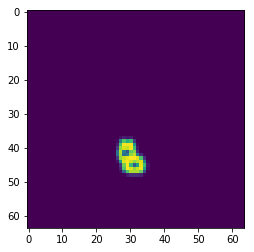

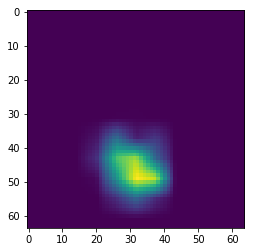

In [61]:
with torch.no_grad():
    x, y = val_set[idx[0]].values()
    x = x[None, :, :].to(device)
    f = model.visualise_features(x, True)
    output = model(x)
    p = np.where(torch.sigmoid(output).data.cpu().numpy() > 0.5)[1]
    y = np.where(y == 1)[0]
    im = x[0][0].cpu().numpy()
    im_f = f

print(y, p)
imshow(im)
imshow(im_f)